In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import boxcox

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [23]:
motorbike_df = pd.read_csv("data/motorbike_updated.csv")
motorbike_df

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day_night
0,1,2011-01-01,0,0,1,0,0,6,0,1,0.24,0.81,0.0000,16,0
1,2,2011-01-01,0,0,1,1,0,6,0,1,0.22,0.80,0.0000,40,0
2,3,2011-01-01,0,0,1,2,0,6,0,1,0.22,0.80,0.0000,32,0
3,4,2011-01-01,0,0,1,3,0,6,0,1,0.24,0.75,0.0000,13,0
4,5,2011-01-01,0,0,1,4,0,6,0,1,0.24,0.75,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,0,1,12,19,0,1,1,2,0.26,0.60,0.1642,119,1
17375,17376,2012-12-31,0,1,12,20,0,1,1,2,0.26,0.60,0.1642,89,1
17376,17377,2012-12-31,0,1,12,21,0,1,1,1,0.26,0.60,0.1642,90,1
17377,17378,2012-12-31,0,1,12,22,0,1,1,1,0.26,0.56,0.1343,61,0


So, firstly i want to test it out on the default **xgboost reggression** model, but with a little adjustments using **GridSearch**. Let's see what results we will get.

In [24]:
motorbike_df = motorbike_df.drop("date", axis=1)

scaler = StandardScaler()

X = motorbike_df.drop(["cnt"], axis=1)
y = motorbike_df["cnt"]

X_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train_unscaled)
x_test = scaler.transform(x_test_unscaled)

In [25]:
xgb_model = xgb.XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

xgb_model_gs = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3)

xgb_model_gs.fit(X_train, y_train)

xgb_pred = xgb_model_gs.predict(x_test)

l_mse_lr = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost Mean Squared Error: {l_mse_lr:.2f}')
l_r2_lr = r2_score(y_test, xgb_pred)
print(f'XGBoost R^2 Score: {l_r2_lr:.2f}')

XGBoost Mean Squared Error: 1544.01
XGBoost R^2 Score: 0.95


**R^2 score is 0.95** which is already very good, and we could stop :)

But, we will train other models too \
Next, i want to try using **BoxCox** method and try to train **NARIMAX** model.

In [26]:
motorbike_df["cnt_boxcox"], lambda_boxcox = boxcox(motorbike_df["cnt"] + 1)  # +1 для уникнення 0
print(f"Box-Cox lambda: {lambda_boxcox:.3f}")

Box-Cox lambda: 0.294


Text(0.5, 1.0, 'Dist With BoxCox')

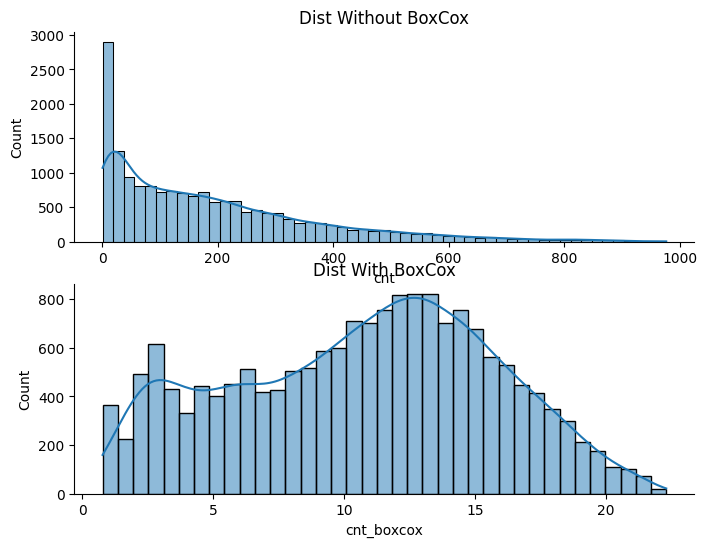

In [27]:
_, ax = plt.subplots(2, 1, figsize=(8,6))
sns.histplot(motorbike_df["cnt"], kde=True, ax=ax[0]).set_title("Dist Without BoxCox")
sns.histplot(motorbike_df["cnt_boxcox"], kde=True, ax=ax[1]).set_title("Dist With BoxCox")

In [33]:
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = model.fit(disp=False)

y_pred = sarimax_result.predict(start=0, end=len(y_test)-1, exog=x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 48.34
R^2 Score: -0.99


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.title('Actual vs Predicted (SARIMAX)')
plt.legend()
plt.show()